<a href="https://colab.research.google.com/github/discofury/DeepLearning/blob/master/Copy_of_lesson1_pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1 - What's your pet

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai import * 
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [0]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



In [0]:
path = untar_data(URLs.PETS)
path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

In [0]:
print(path_anno)

/root/.fastai/data/oxford-iiit-pet/annotations


The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [0]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_148.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bombay_186.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_14.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/shiba_inu_131.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_141.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

In [0]:
224 / 7

32.0

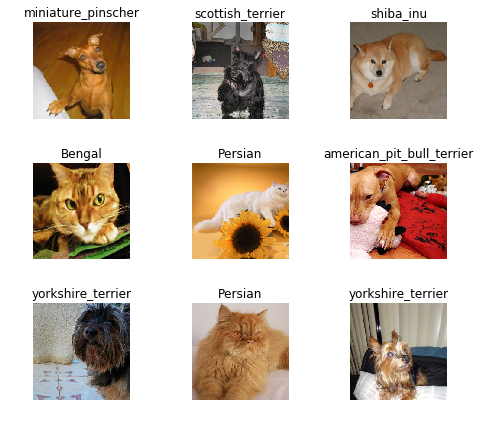

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
help(ImageDataBunch)

Help on class ImageDataBunch in module fastai.vision.data:

class ImageDataBunch(fastai.basic_data.DataBunch)
 |  DataBunch suitable for computer vision.
 |  
 |  Method resolution order:
 |      ImageDataBunch
 |      fastai.basic_data.DataBunch
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  batch_stats(self, funcs:Collection[Callable]=None, ds_type:fastai.basic_data.DatasetType=<DatasetType.Train: 1>) -> torch.Tensor
 |      Grab a batch of data and call reduction function `func` per channel
 |  
 |  normalize(self, stats:Collection[torch.Tensor]=None, do_x:bool=True, do_y:bool=False) -> None
 |      Add normalize transform using `stats` (defaults to `DataBunch.batch_stats`)
 |  
 |  ----------------------------------------------------------------------
 |  Class methods defined here:
 |  
 |  create_from_ll(lls:fastai.data_block.LabelLists, bs:int=64, val_bs:int=None, ds_tfms:Union[Callable, Collection[Callable], NoneType]=None, num_workers:int=2, dl_tfms:Union[Coll

In [0]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 59543870.98it/s]


In [0]:
# this is not run in the video...
#learn.model

In [0]:
# note that this takes ~90s per cycle
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.400786,0.339027,0.098782,01:30
1,0.545740,0.264708,0.082544,01:30
2,0.345645,0.228755,0.074425,01:29
3,0.267431,0.222872,0.073072,01:29


In [0]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [0]:
# so it is supposed to be purple... https://forums.fast.ai/t/plot-top-losses-returns-images-with-weird-flashing-light/39141
interp.plot_top_losses(9, figsize=(15,11))
#interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

In [0]:
#pip install nbconvert=5.4.1

In [0]:
# according to the forum doc is not working in colab
# https://forums.fast.ai/t/doc-function-was-working-fine-yesterday-wont-anymore-on-colab/44929/11
#doc(interp.plot_top_losses)

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=2)

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1)

In [0]:
learn.load('stage-1');

In [0]:
learn.lr_find()

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8)

In [0]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

If it doesn't, you can always go back to your previous model.

In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)

## Other data formats

In [0]:
path = untar_data(URLs.MNIST_SAMPLE); path

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26) # this is how to create data bunch from folder name

In [0]:
data.show_batch(rows=3, figsize=(5,5))

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

In [0]:
df = pd.read_csv(path/'labels.csv')
df.head()

In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

In [0]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [0]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

In [0]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

In [0]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

In [0]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

In [0]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

In [0]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

# Download our own set of pictures

This is where we attempt to download our own set of pictures. 

The plan is to use cars to work out what is going on: 

* Lee: Ferrari, Lambourginhi, Audi, BMW, Merecedes
* Jon: Ford, Fiat, Volvo, Toyota, Honda

Potential link of use: [RealPython Storing images in Python](https://realpython.com/storing-images-in-python/)




In [0]:
pip install google-images-download

In [0]:
from google_images_download import google_images_download

In [0]:
response = google_images_download.googleimagesdownload()

## Something what I found on the Internet

[This page](https://medium.com/@gianfrancescoangelini/how-to-create-a-dataset-in-google-colab-for-your-machine-learning-projects-c1852d62936e) looks to be of use, How to create a dataset in Google Colab for your ML projects. 

These two pages look good too:

* [Someone's notes from lesson two](https://github.com/hiromis/notes/blob/master/Lesson2.md)
* [How to create a deep learning dataset using Google Images](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/) 
* [Downloading datasets into Google Drive via Google Colab](https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166)
* [More info on how get images into Drive](https://medium.freecodecamp.org/how-to-build-the-best-image-classifier-3c72010b3d55)

The `wget` command was selected from this page

Note one key thing to do is unhide the navigation bar on the LHS. Look at Files, then the /content/ directory. Running the scripts below will put images into the /content/downloads/ directory

In [0]:
!wget https://chromedriver.storage.googleapis.com/2.42/chromedriver_linux64.zip  && unzip chromedriver_linux64

In [0]:
colab_path = '/gdrive/../content/'
chromedriver_path = '/gdrive/../content/chromedriver'

In [0]:
print(colab_path)

In [0]:
#Mount the drive from Google to save the dataset
from google.colab import drive # this will be our driver
drive.mount('/content/gdrive')
root = '/gdrive/My Drive/DeepLearning/'     # if you want to operate on your Google Drive

The following saves images to `\content\downloads\whatever_the_keyword_is`

In [0]:
from google_images_download import google_images_download   #importing the library

# using something like (1) below allows you to use multiple keywords at once, it just screws up the section below
# when it attempts to look in a certain directory for an example
keyws   = "shiba" # (1) 
limit   = 100
chromedriver = chromedriver_path
offset  = None  # how many links to skip
color_type	= None# color type you want to apply to the images.[full-color, black-and-white, transparent]
size    = None  #relative size of the image to be downloaded. [large, medium, icon, >400*300, >640*480, >800*600, >1024*768, >2MP, >4MP, >6MP, >8MP, >10MP, >12MP, >15MP, >20MP, >40MP, >70MP]
usage_rights	= None #Very important! Check the doc

arguments = {
        "keywords" : keyws,
        "limit" :limit,
        "chromedriver":chromedriver,
        "offset" : offset,
        "color_type" : color_type,
        "size" : size,
        "usage_rights" : usage_rights
        }   #creating list of arguments
response  = google_images_download.googleimagesdownload()   #class instantiation
response.download(arguments)  

In [0]:
dataset_path = 'downloads/' + keyws + '/'
dataset = [ dataset_path + img_name for img_name in drive._os.listdir( colab_path + dataset_path ) ]
dataset[:10]  #Peek the first ten

In [0]:
print(colab_path + dataset_path)

[Help on loading data into an ImageDataBunch from a folder](https://docs.fast.ai/vision.data.html#ImageDataBunch.from_folder)

In [0]:
path = colab_path + "downloads/shiba/"
verify_images(path, delete=True, max_workers=8)

From [here](https://github.com/hiromis/notes/blob/master/Lesson2.md)

>Whenever you create a data bunch, if you don't have a separate training and validation set, then you can just say the training set is in the current folder (i.e. . because by default, it looks in a folder called train) and I want you to set aside 20% of the data, please. So this is going to create a validation set for you automatically and randomly. You'll see that whenever I create a validation set randomly, I always set my random seed to something fixed beforehand. This means that every time I run this code, I'll get the same validation set. In general, I'm not a fan of making my machine learning experiments reproducible (i.e. ensuring I get exactly the same results every time). The randomness is to me a really important part of finding out your is solution stable and it is going to work each time you run it. But what is important is that you always have the same validation set. Otherwise when you are trying to decide has this hyper parameter change improved my model but you've got a different set of data you are testing it on, then you don't know maybe that set of data just happens to be a bit easier. So that's why I always set the random seed here.

```
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

```

In [0]:
np.random.seed(42)

tfms = get_transforms(do_flip=False)
#path = colab_path + "downloads/shiba/"
path = colab_path + "downloads/"
print(path)
data = ImageDataBunch.from_folder(path,train=".", valid_pct=0.2, ds_tfms=tfms, size=26) # this is how to create data bunch from folder name

In [0]:
data.classes

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow( plt.imread( dataset[6] ) )
plt.grid(b=None) #remove grid

## My original attempt using the google_images_download library

In [0]:
#arguments = {"keywords":"Polar bears,baloons,Beaches","limit":20,"print_urls":True}   #creating list of arguments
arguments = {"keywords":"Toyota","limit":20,"print_urls":True}   #creating list of arguments
paths = response.download(arguments) 